In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv1D, Conv1DTranspose, LeakyReLU, BatchNormalization, Embedding, Multiply
from keras.layers import Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the generator network:

def build_generator(latent_dim, num_classes, time_series_length):
    input_noise = Input(shape=(latent_dim,))
    input_label = Input(shape=(1,))
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(input_label))
    model_input = Multiply()([input_noise, label_embedding])
    
    x = Dense(128)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(time_series_length, activation="tanh")(x)
    model = Model([input_noise, input_label], x)
    
    return model

# Define the discriminator network:

def build_discriminator(num_classes, time_series_length):
    input_data = Input(shape=(time_series_length,))
    input_label = Input(shape=(1,))
    label_embedding = Flatten()(Embedding(num_classes, time_series_length)(input_label))
    model_input = Reshape((time_series_length, 1))(input_data)
    model_input = Multiply()([model_input, label_embedding])

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(model_input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model([input_data, input_label], x, name="discriminator")
    return model

# Create the conditional GAN model:

def build_cgan(generator, discriminator):
    z = Input(shape=(latent_dim,))
    label = Input(shape=(1,))
    time_series = generator([z, label])
    validity = discriminator([time_series, label])
    cgan = Model([z, label], validity)
    
    return cgan



# def train_cgan(generator, discriminator, cgan, epochs, batch_size, latent_dim, num_classes, x_train, y_train):
#     real = np.ones((batch_size, 1))
#     fake = np.zeros((batch_size, 1))

#     for epoch in range(epochs):
#         for batch_idx in range(num_batches):
#             # Load a batch of data
#             real_time_series, labels = data_loader(batch_size)

#             # Generate a batch of fake time series data
#             noise = np.random.normal(0, 1, (batch_size, latent_dim))
#             gen_time_series = generator.predict([noise, labels])
    
#             # Train the discriminator on both real and fake data
#             d_loss_real = discriminator.train_on_batch([real_time_series, labels], real)
#             d_loss_fake = discriminator.train_on_batch([gen_time_series, labels], fake)
#             d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

#             # Sample new labels for each batch
#             sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

#             # Train the generator to generate real-looking data
#             g_loss = cgan.train_on_batch([noise, sampled_labels], real)

#         if epoch % 100 == 0:
#             print(f"Epoch: {epoch}, D loss: {d_loss[0]}, G loss: {g_loss}")

In [2]:

# This is the data we load into the model we will have to replace this with actual data
def load_sine_wave(num_samples, time_series_length):
    # Generate sine wave data
    t = np.linspace(0, 2*np.pi, time_series_length)
    data = np.sin(t).reshape(1, -1)

    # Repeat and stack data to generate num_samples time series
    data = np.repeat(data, num_samples, axis=0)

    # Generate corresponding labels (in this case, all 0s)
    labels = np.zeros((num_samples, 1))

    return data, labels


In [3]:
# Define hyperparameters
latent_dim = 100
num_classes = 10
time_series_length = 100
epochs = 5000
batch_size = 32

# Build the generator, discriminator, and CGAN models
generator = build_generator(latent_dim, num_classes, time_series_length)
discriminator = build_discriminator(num_classes, time_series_length)
cgan = build_cgan(generator, discriminator)


# Compile the discriminator and CGAN models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
cgan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Load data
x_train, y_train = load_sine_wave(num_classes, time_series_length)

# Train the CGAN model
for epoch in range(epochs):
   
    #  Train Discriminator
   

    # Select a random batch of time series and labels
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_time_series = x_train[idx]
    labels = y_train[idx]

    # Generate a batch of fake time series
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_time_series = generator.predict([noise, labels])

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([real_time_series, labels], np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch([gen_time_series, labels], np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    
    #  Train Generator
    

    # Generate a batch of noise and labels
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)

    # Train the generator
    g_loss = cgan.train_on_batch([noise, sampled_labels], np.ones((batch_size, 1)))

    # Print training progress
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, D loss: {d_loss[0]}, G loss: {g_loss}")

# Save the generator model
generator.save('generator_model.h5')

1/1 [==============================] - 0s 80ms/step
Epoch: 0, D loss: 0.6882172524929047, G loss: 0.6938056349754333
1/1 [==============================] - 0s 11ms/step
Epoch: 100, D loss: 0.34283437952399254, G loss: 0.5206794142723083
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 200, D loss: 0.2784000337123871, G loss: 0.1550433337688446
1/1 [==============================] - 0s 11ms/step
Epoch: 300, D loss: 0.3529433310031891, G loss: 0.12641794979572296
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 400, D loss: 0.20298868417739868, G loss: 0.15647828578948975
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 500, D loss: 0.15117979235947132, G loss: 0.24588051438331604
1/1 [==============================] - 0s 11ms/step
Epoch: 600, D loss: 0.1443357914686203, G loss: 0.31211575865745544
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 700, D loss: 0.23470410704612732, G loss: 0.29326948523521423
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 800, D loss: 0.17769016325473785, G loss: 0.2488097995519638
1/1 [==============================] - 0s 10ms/step
Epoch: 900, D loss: 0.15650894306600094, G loss: 0.11148503422737122
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 1000, D loss: 0.13888687267899513, G loss: 0.3197019398212433
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 1100, D loss: 0.210357666015625, G loss: 0.08094465732574463
1/1 [==============================] - 0s 10ms/step
Epoch: 1200, D loss: 0.211220633238554, G loss: 0.5329648852348328
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 1300, D loss: 0.17802367731928825, G loss: 0.05960743874311447
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 1400, D loss: 0.11225236020982265, G loss: 0.5017962455749512
1/1 [==============================] - 0s 10ms/step
Epoch: 1500, D loss: 0.21915152668952942, G loss: 0.174262136220932
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 1600, D loss: 0.20851833373308182, G loss: 0.19272732734680176
1/1 [==============================] - 0s 10ms/step
Epoch: 1700, D loss: 0.18858209252357483, G loss: 0.20309516787528992
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 1800, D loss: 0.26080984622240067, G loss: 0.16937413811683655
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 1900, D loss: 0.23128031194210052, G loss: 0.4383179843425751
1/1 [==============================] - 0s 10ms/step
Epoch: 2000, D loss: 0.3335009329020977, G loss: 0.33005857467651367
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 2100, D loss: 0.2847167029976845, G loss: 0.2718738317489624
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 2200, D loss: 0.3057163953781128, G loss: 0.4965745210647583
1/1 [==============================] - 0s 10ms/step
Epoch: 2300, D loss: 0.32247765734791756, G loss: 0.10205473005771637
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 2400, D loss: 0.32714615389704704, G loss: 0.8155059218406677
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 2500, D loss: 0.22581113874912262, G loss: 0.5688610076904297
1/1 [==============================] - 0s 11ms/step
Epoch: 2600, D loss: 0.26255015656352043, G loss: 0.33667394518852234
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 2700, D loss: 0.1446024402976036, G loss: 0.27351468801498413
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 2800, D loss: 0.2787805311381817, G loss: 8.30864446470514e-05
1/1 [==============================] - 0s 11ms/step
Epoch: 2900, D loss: 0.25308314710855484, G loss: 0.4975021183490753
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 3000, D loss: 0.2919943928718567, G loss: 0.2708314061164856
1/1 [==============================] - 0s 11ms/step
Epoch: 3100, D loss: 0.2553291693329811, G loss: 0.31375056505203247
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 3200, D loss: 0.2611401490867138, G loss: 0.0004525018739514053
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 3300, D loss: 0.4829854778945446, G loss: 0.6070865392684937
1/1 [==============================] - 0s 10ms/step
Epoch: 3400, D loss: 0.3532809726893902, G loss: 0.4038012623786926
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 3500, D loss: 0.47206541523337364, G loss: 0.2079697996377945
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 3600, D loss: 0.33280862122774124, G loss: 0.38607871532440186
1/1 [==============================] - 0s 11ms/step
Epoch: 3700, D loss: 0.2561470866203308, G loss: 0.2662421762943268
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 3800, D loss: 0.3107899948954582, G loss: 0.3560571074485779
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 3900, D loss: 0.2583600990474224, G loss: 0.4029828608036041
1/1 [==============================] - 0s 11ms/step
Epoch: 4000, D loss: 0.16625336557626724, G loss: 0.2843562066555023
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 4100, D loss: 0.23441201075911522, G loss: 0.3869782090187073
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 4200, D loss: 0.32916656881570816, G loss: 0.04258117452263832
1/1 [==============================] - 0s 11ms/step
Epoch: 4300, D loss: 0.23128775507211685, G loss: 0.2581714689731598
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 4400, D loss: 0.40391371957957745, G loss: 0.26579785346984863
1/1 [==============================] - 0s 10ms/step
Epoch: 4500, D loss: 0.2586784455925226, G loss: 0.10443489253520966
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 4600, D loss: 0.295309629291296, G loss: 0.2919839322566986
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Epoch: 4700, D loss: 0.2634441740810871, G loss: 0.3935862183570862
1/1 [==============================] - 0s 10ms/step
Epoch: 4800, D loss: 0.20142900943756104, G loss: 0.23363228142261505
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Epoch: 4900, D loss: 0.24419791623950005, G loss: 0.4044303297996521
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


4/4 [==============================] - 0s 667us/step


C:\Users\16148\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


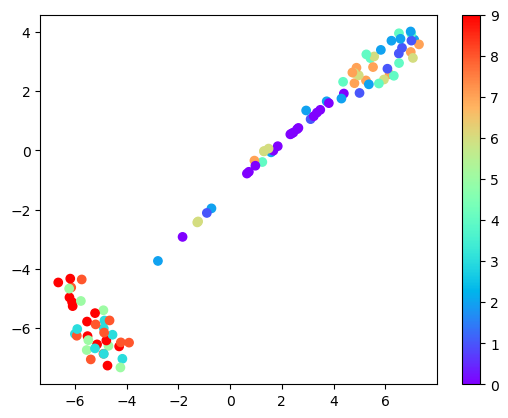

In [4]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Generate some fake time series data using the CGAN model
latent_points = np.random.normal(0, 1, (100, latent_dim))
labels = np.random.randint(0, num_classes, 100).reshape(-1, 1)
generated_data = generator.predict([latent_points, labels])

# Apply t-SNE to the generated data to visualize it in 2D space
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate=200.0)
tsne_data = tsne.fit_transform(generated_data)

# Plot the t-SNE visualization
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels.flatten(), cmap='rainbow')
plt.colorbar()
plt.show()

<AxesSubplot:>

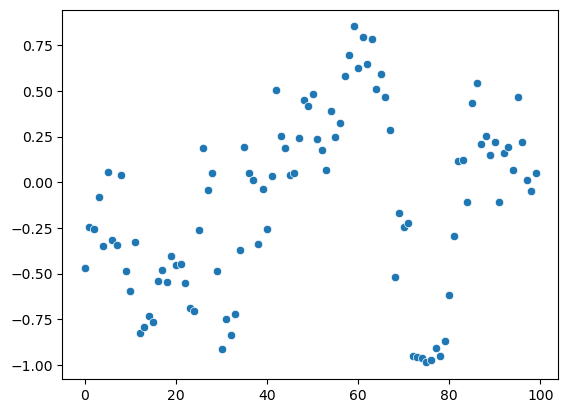

In [6]:
import seaborn as sns
x = np.arange(0,100)
sns.scatterplot(x=x, y=generated_data[0])